Music generation using VAE

In [1]:
from utils import *
from raw_dataset import  AudioDataset
from hyperparams import RawHyperParams
import os 
import random
import logging
import torch
import json
from dataclasses import asdict
import torch.nn as nn 
import torch.optim as optim
import torchaudio as taudio
import matplotlib.pyplot as plt

from typing import Tuple, Callable
from earlystopping import EarlyStopping
from resnetvae import ResenetVAE
from raw_audio_dataloader import get_train_val_loaders

In [2]:
hyper_params = RawHyperParams()

Audio preprocessing 

In [3]:
genres = "jazz"
blues_path = f"{HyperParams.data_genres_original_dir}/{genres}"
rand = random.randint(0,9)
audio_path = os.path.join(blues_path, f"{genres}.0000{rand}.wav")
sr, channels, duration = get_audio_metadata(audio_path)
print(f"filename: {audio_path} | sampling rate: {sr} | channels: {channels} | duration: {duration}")

filename: data/genres_original/jazz/jazz.00009.wav | sampling rate: 22050 | channels: 1 | duration: 30.013333333333332


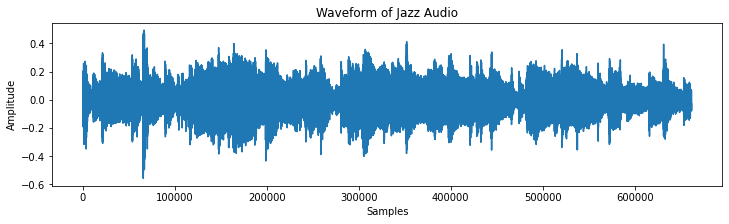

In [4]:
waveform, sr = taudio.load(audio_path)
plt.figure(figsize=(12, 3))
plt.plot(waveform.t().numpy())
plt.title("Waveform of Jazz Audio")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

Since we have large data dimension for each audio, lets convert it to spectrogram. 

In [5]:
create_spectrogram = False
if create_spectrogram:
    convert_audio_to_spectrogram(
    root_dir=hyper_params.data_genres_original_dir,
    save_dir=hyper_params.spectrogram_data_dir,
    sample_rate=hyper_params.sampling_rate,
    duration=hyper_params.duration,
    n_fft=hyper_params.n_fft,
    hop_length=hyper_params.hop_length,
    n_mels=hyper_params.n_mels
)

In [6]:
# raw_dataset = AudioDataset(raw_hp=hyper_params)
# data_mean, data_std = compute_audio_stats(raw_dataset)
# print(f"raw data mean:{data_mean}, std: {data_std}")
## raw data mean:-0.0007609116146340966, std: 0.14416882395744324

In [7]:
train_loader, val_loader = get_train_val_loaders(raw_hp=hyper_params)

test_spctro, lable_spectro = next(iter(train_loader))

# test_spctro.size()
# print(f"Min value: {test_spctro.min(dim=2)}, Max value: {test_spctro.max(dim=2)}, Batch shape:{test_spctro.size()}")

Skipping corrupt file: data/genres_original/jazz/jazz.00054.wav - Error opening 'data/genres_original/jazz/jazz.00054.wav': Format not recognised.


In [8]:
global_min = float('inf')
global_max = float('-inf')

for images, labels in train_loader:
    # Compute min and max for the current batch
    batch_min = images.min()
    batch_max = images.max()
    
    # Update global min and max
    global_min = min(global_min, batch_min.item())
    global_max = max(global_max, batch_max.item())

print("Train Global min value:", global_min)
print("Train Global max value:", global_max)

global_min = float('inf')
global_max = float('-inf')


for images, labels in val_loader:
    # Compute min and max for the current batch
    batch_min = images.min()
    batch_max = images.max()
    
    # Update global min and max
    global_min = min(global_min, batch_min.item())
    global_max = max(global_max, batch_max.item())

print("Val Global min value:", global_min)
print("Val Global max value:", global_max)

Train Global min value: -1.2130751609802246
Train Global max value: 1.2368879318237305
Val Global min value: -1.1235309839248657
Val Global max value: 1.1396068334579468


In [9]:
print(f"Train dataset: {len(train_loader)}, Val dataser: {len(val_loader)}")

Train dataset: 13, Val dataser: 4


Training and Validating model 

In [ ]:
# Criterion is (reconstruction, target, mu, logvar) -> (total_loss, mse_loss, kl_loss)
CriterionType = Callable[[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor],
                           Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]

def validate(model: ResenetVAE, val_loader: DataLoader, criterion: CriterionType, device: torch.device) -> Tuple[float, float, float]:
    model.eval()
    total_mse_loss: float = 0.0
    total_kl_loss: float = 0.0 
    total_loss: float = 0.0

    with torch.no_grad():
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            recon, mu, log_var = model(inputs)
            loss, mse_loss, kl_loss = criterion(inputs, recon , mu, log_var)
            
            total_mse_loss += mse_loss.item()
            total_kl_loss += kl_loss.item()
            total_loss += loss.item()
    
    avg_total_loss: float = total_loss / len(val_loader)
    avg_mse_loss: float = total_mse_loss / len(val_loader)
    avg_kl_loss: float = total_kl_loss / len(val_loader)

    return avg_total_loss, avg_mse_loss, avg_kl_loss



def train(model: ResenetVAE, train_loader: DataLoader, val_loader: DataLoader, criterion: CriterionType, optimizer: optim.Optimizer, hp: RawHyperParams, es: EarlyStopping) -> None:
    logs: list[dict] = []
    model.to(hp.device)
    print(f"Training model on {hp.device}")
    
    for epoch in range(hp.num_epochs):
        model.train()
        train_mse: float = 0.0
        train_kl: float = 0.0 
        train_total: float = 0.0 

        for batch_idx, (inputs, _) in enumerate(train_loader):
            inputs = inputs.to(hp.device)
            optimizer.zero_grad()

            recon, mu, log_var = model(inputs)
            loss, mse_loss, kl_loss = criterion(inputs, recon , mu, log_var)
            loss.backward()            
            optimizer.step()

            train_mse += mse_loss.item()
            train_kl += kl_loss.item()
            train_total += loss.item()
            
            if batch_idx % 5 == 0:
                print(f"[B: {batch_idx}] ==> Latent stats: μ={mu.mean().item():.3f}±{mu.std().item():.3f}, logσ²={log_var.mean().item():.3f}")
        # Compute averages over training batches.
        train_total /= len(train_loader)
        train_mse   /= len(train_loader)
        train_kl    /= len(train_loader)
        
        # Evaluate on the validation set.
        val_total, val_mse, val_kl = validate(model, val_loader, criterion, hp.device)

        log_data = {
            "epoch": epoch,
            "train_mse_loss": train_mse,
            "train_kl_loss": train_kl,
            "train_total_loss": train_total,
            "val_mse_loss": val_mse,
            "val_kl_loss": val_kl,
            "val_total_loss": val_total
        }
        logs.append(log_data)

        print(f"Epoch {epoch} | Train Loss: {train_total:.4f} | Val Loss: {val_total:.4f}")

        es(val_loss=val_total, model=model, model_dir=hp.model_dir, model_file_name=hp.model_file_name)
        if es.early_stop: 
            print("Early stop triggered !!")
            break
    
    # Save training logs to a JSON file.
    os.makedirs(hp.log_dir, exist_ok=True)
    log_path = os.path.join(hp.log_dir, hp.train_log_file)
    with open(log_path, 'w') as f:
        json.dump(logs, f, indent=4)
    
    print(f"Training logs saved to {log_path}")


In [11]:
print(f"Hyperparams:\n {asdict(hyper_params)}")

Hyperparams:
 {'device': device(type='cuda'), 'batch_size': 64, 'validation_size': 0.2, 'num_blocks': 2, 'latent_dim': 32, 'input_size': (90000, 1), 'input_channels': 1, 'input_length': 90000, 'hidden_dims': (16, 32), 'lr': 1e-05, 'num_epochs': 50, 'block_type_encoder': 'encoder', 'block_type_decoder': 'decoder', 'data_root_dir': 'data', 'data_genres_original_dir': 'data/genres_original', 'data_images_original_dir': 'data/images_original', 'spectrogram_data_dir': 'data/spectrograms', 'model_dir': 'models', 'model_file_name': 'resenet_vae.pth', 'output_dir': 'outputs', 'output_audio_dir': 'outputs/audio', 'log_dir': 'log', 'train_log_file': 'trainlog.json', 'sampling_rate': 3000, 'duration': 30, 'offset': 0.0, 'mean': -0.000761, 'std': 0.143788}


In [12]:
model = ResenetVAE(hyperparams=hyper_params)
total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params}")
print(model)

Model parameters: 69894428
ResenetVAE(
  (encoder): Sequential(
    (0): Resnet1dBlock(
      (activation): ReLU(inplace=True)
      (block): Sequential(
        (0): Conv1d(1, 16, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (downsample): Sequential(
        (0): Conv1d(1, 16, kernel_size=(1,), stride=(2,))
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Resnet1dBlock(
      (activation): ReLU(inplace=True)
      (block): Sequential(
        (0): Conv1d(16, 32, kernel_size=(3,), stride=(2,), padding=(1,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inpl

Training model on cuda
[B: 0] ==> Latent stats: μ=-0.097±0.611, logσ²=0.071
[B: 5] ==> Latent stats: μ=-0.344±1.634, logσ²=-1.199
[B: 10] ==> Latent stats: μ=0.263±1.177, logσ²=-2.479
Epoch 0 | Train Loss: 4397.5645 | Val Loss: 191.4282
[B: 0] ==> Latent stats: μ=-0.019±0.963, logσ²=-1.660
[B: 5] ==> Latent stats: μ=-0.037±0.731, logσ²=-1.560
[B: 10] ==> Latent stats: μ=0.050±0.606, logσ²=-1.347
Epoch 1 | Train Loss: 2241.4310 | Val Loss: 318.8623
[B: 0] ==> Latent stats: μ=-0.145±0.753, logσ²=-1.183
[B: 5] ==> Latent stats: μ=0.075±0.645, logσ²=-1.190
[B: 10] ==> Latent stats: μ=-0.062±0.503, logσ²=-1.018
Epoch 2 | Train Loss: 1441.5281 | Val Loss: 182.6913
[B: 0] ==> Latent stats: μ=0.013±0.459, logσ²=-0.759
[B: 5] ==> Latent stats: μ=0.021±0.436, logσ²=-0.741
[B: 10] ==> Latent stats: μ=-0.016±0.410, logσ²=-0.424
Epoch 3 | Train Loss: 791.1989 | Val Loss: 291.0041
[B: 0] ==> Latent stats: μ=0.035±0.360, logσ²=-0.373
[B: 5] ==> Latent stats: μ=-0.031±0.334, logσ²=-0.506
[B: 10] ==> L

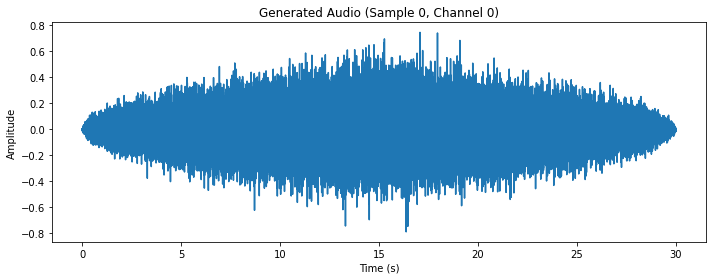

In [13]:
optimizer = optim.Adam(model.parameters(), lr = hyper_params.lr)
es = EarlyStopping(patience=5, min_delta=0.001)

set_train = True
load_and_train = False

if set_train:
    train(model=model, train_loader=train_loader, val_loader=val_loader, criterion=vae_loss, optimizer=optimizer, hp=hyper_params, es=es)

elif load_and_train:
    print(f"loading the model  from: {hyper_params.model_dir}/{hyper_params.model_file_name}")
    model.load_checkpoint(f"{hyper_params.model_dir}/{hyper_params.model_file_name}", hyper_params.device)
    train(model=model, train_loader=train_loader, val_loader=val_loader, criterion=vae_loss, optimizer=optimizer, hp=hyper_params, es=es)

else: model.load_checkpoint(f"{hyper_params.model_dir}/{hyper_params.model_file_name}", hyper_params.device)
# model.load_checkpoint(f"{hyper_params.model_dir}/{hyper_params.model_file_name}", hyper_params.device)
generated_audio = model.generate(hp=hyper_params, num_samples=5)
plot_generated_audio(generated_audio, sample_rate=hyper_params.sampling_rate)

### 1. Audio Fundamentals

#### **Digital Audio Basics**
- **Sampling Rate:**  
  The number of samples taken per second (measured in Hertz). For music, common rates include 22.05 kHz, 44.1 kHz, or higher. A higher sampling rate can capture more detail but increases data size.
- **Bit Depth:**  
  Determines the resolution or dynamic range of each sample (e.g., 16-bit, 24-bit). Higher bit depth improves audio fidelity.
- **Time-Domain Representation:**  
  The raw waveform that shows amplitude changes over time.

#### **Frequency-Domain Representation**
- **Fourier Transform:**  
  Converts time-domain signals into frequency components. This is key to analyzing and processing musical content.
- **Short-Time Fourier Transform (STFT):**  
  Applies the Fourier transform over short overlapping windows. This produces a time-frequency representation known as a spectrogram.
- **Spectrogram:**  
  A visual representation of the spectrum of frequencies in a signal as they vary with time. It’s widely used as input for deep models.
- **Mel Scale & Mel Spectrogram:**  
  The Mel scale is a perceptual scale of pitches judged by listeners to be equal in distance. A Mel spectrogram maps the frequencies to this scale, often used in music and speech tasks.
- **MFCC (Mel-Frequency Cepstral Coefficients):**  
  These coefficients capture the timbral texture of audio, summarizing the spectral envelope and are often used in classification tasks.


### 2. Preprocessing Steps

#### **A. Loading and Resampling**
- **Loading Audio:**  
  Use libraries such as [Librosa](https://librosa.org/) or PyDub to load audio files. Audio is typically loaded as a time series array.
- **Resampling:**  
  Ensure all audio samples have the same sampling rate. Resampling is important for consistency across your dataset.


#### **B. Normalization and Standardization**
- **Amplitude Normalization:**  
  Scale the waveform so that its values lie within a specific range (e.g., -1 to 1). This helps the model learn without being skewed by large variations in volume.
- **Standardization:**  
  Adjust the signal to have zero mean and unit variance, which can be beneficial for certain neural network architectures.


#### **C. Windowing and Framing**
- **Framing:**  
  Divide the audio signal into short frames (e.g., 20-40 ms). This is critical when computing STFT since audio properties are often assumed to be stationary over short periods.
- **Windowing:**  
  Apply a window function (like Hann or Hamming) to each frame to reduce spectral leakage when performing Fourier analysis.

#### **D. Feature Extraction**
- **STFT and Spectrogram:**  
  Compute the STFT to convert your signal into a 2D time-frequency representation. Then take the magnitude (absolute value) to obtain the spectrogram.
- **Mel Spectrogram:**  
  Transform the spectrogram onto the Mel scale. This often aligns better with human auditory perception.
- **MFCCs:**  
  Optionally, compute MFCCs if your generative model benefits from compact representations of timbre.


#### **E. Data Augmentation (Optional)**
- **Noise Injection:**  
  Adding small amounts of noise can help the model generalize.
- **Time Stretching & Pitch Shifting:**  
  These techniques increase dataset diversity by simulating variations in speed and pitch.


### 3. Considerations for Deep Generative Models

- **Representation Choice:**  
  Decide whether to use raw waveforms or transformed representations (spectrograms, Mel spectrograms, or MFCCs).  
  - **Raw Waveforms:** Offer all information including phase but are high-dimensional.
  - **Spectrograms/Mel Spectrograms:** Reduce dimensionality and can highlight perceptually relevant features.
- **Phase Information:**  
  Some generative models (like WaveNet) work directly on waveforms and implicitly model phase, while models based on spectrograms often need phase reconstruction (using techniques like the Griffin-Lim algorithm) to convert back to time-domain audio.
- **Model Input Size:**  
  Ensure your preprocessed data has consistent dimensions. This may involve trimming, padding, or segmenting the audio into fixed-length excerpts.


### 4. Summary

In summary, the preprocessing pipeline typically includes:
1. **Loading audio** with a consistent sampling rate.
2. **Normalizing** the amplitude of the waveform.
3. **Windowing and framing** the signal for time-frequency analysis.
4. **Extracting features** such as spectrograms, Mel spectrograms, or MFCCs.
5. Optionally applying **data augmentation** techniques to enrich your dataset.

By transforming the raw audio into these structured representations, we prepare the data for training deep generative models effectively, capturing both temporal and spectral nuances essential for realistic music generation.
